<a href="https://colab.research.google.com/github/IsraBazzar/RealEstatePriceEstimator/blob/main/Group_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Real Estate Price Estimator

Pricing properties appropriately in the real estate market can make or break a sale. This challenge entails creating a sophisticated tool where users can input property attributes (e.g., number of rooms, location, area, etc.) and obtain an accurate market price prediction.


## Importing required libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sb
import statsmodels.api as sm
import matplotlib.pyplot as plt
from patsy import dmatrices
import matplotlib.pyplot as plt
from matplotlib import style

%matplotlib inline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb


In [ ]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/content/housing.csv'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

**Helper functions**

In [ ]:
def print_num_of_outlier(col, data):
    """
      print number of outlier in the column (col)
    """
    Q1  = data[col].quantile(0.25)
    Q3  = data[col].quantile(0.75)

    IQR = Q3 -Q1
    lower_bound= Q1 - 1.5*IQR
    upper_bound= Q3 + 1.5*IQR

    num_of_population_outliers = data[(data[col] > upper_bound) | (data[col] < lower_bound)][col].count()
    percentage_of_population_outliers = num_of_population_outliers / data[c].count()

    print("number of outliers in columns {} is {}".format(col, num_of_population_outliers))
    print("percentage  of outliers in columns {} is {}".format(col, percentage_of_population_outliers))

def drop_outlier(col, data):
    """
      drop outliers that not satisfy IQR rule
    """
    Q1  = data[col].quantile(0.25)
    Q3  = data[col].quantile(0.75)

    IQR = Q3 -Q1
    lower_bound= Q1 - 1.5*IQR
    upper_bound= Q3 + 1.5*IQR

    outliers_indices = data[(data[col] > upper_bound) | (data[col] < lower_bound)].index
    # print(outliers_indices)
    data.drop(axis=0, index=outliers_indices, inplace = True)




## Data Analysis

### Import housing data

In [ ]:
# import required libraries

# import the dataset
data = pd.read_csv('/content/housing.csv')

# df_copy = df.copy()
# df_copy.head()
data.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

### Inspect features and data types


In [ ]:
# to see the features' datatypes and
# to make sure the datatypes are what we expect.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [ ]:
print("Features names:")
data.columns

Features names:


Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

### Univariant analysis

#### Median age¶


In [ ]:
data.housing_median_age.describe()

count    20640.000000
mean        28.639486
std         12.585558
min          1.000000
25%         18.000000
50%         29.000000
75%         37.000000
max         52.000000
Name: housing_median_age, dtype: float64

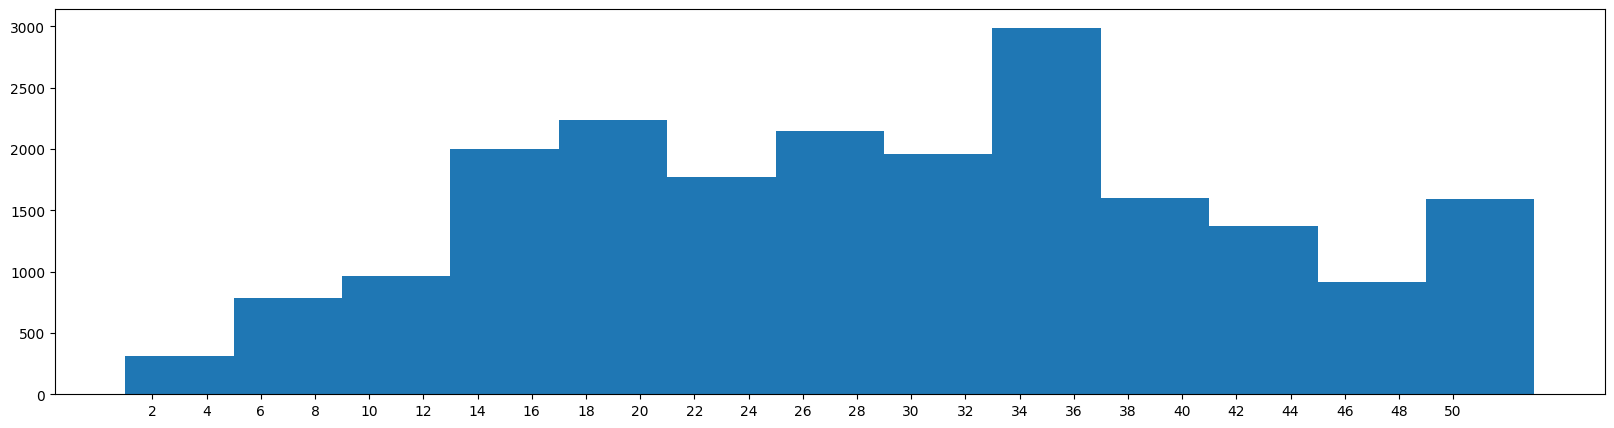

In [ ]:
# import matplotlib.pyplot as plt

plt.figure(figsize=[20,5])

plt.subplot(1, 1, 1)

bin_edges = np.arange(1, 52+4, 4)

plt.hist(data=data, x='housing_median_age', bins = bin_edges);
plt.xticks(np.arange(2, 52  , 2));

#### Total_rooms

<Axes: xlabel='housing_median_age'>

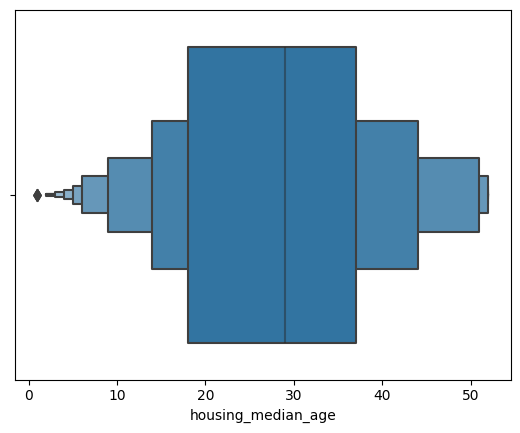

In [ ]:
sb.boxenplot(data =data, x= 'housing_median_age')

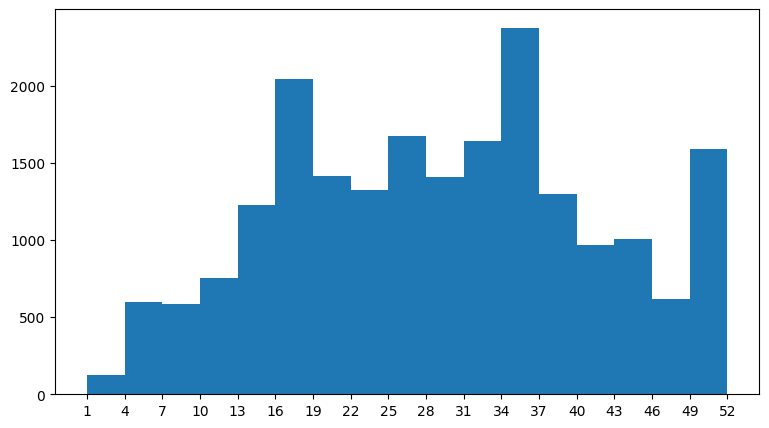

In [ ]:
plt.figure(figsize=[20,5])

plt.subplot(1, 2, 1)

bin_edges = np.arange(1, 52+3, 3)

plt.hist(data=data, x='housing_median_age', bins = bin_edges);
plt.xticks(np.arange(1, 52 + 3, 3));

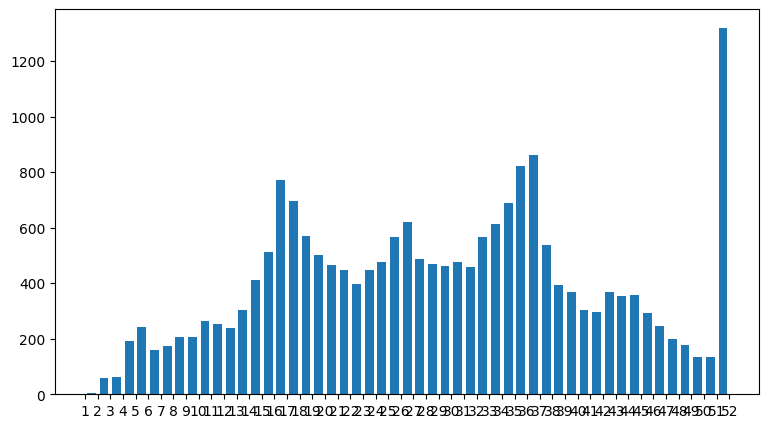

In [ ]:
plt.figure(figsize=[20,5])

plt.subplot(1, 2, 1)

bin_edges = np.arange(1, 52+1, 1)

plt.hist(data=data, x='housing_median_age', bins = bin_edges,  rwidth = 0.7);
plt.xticks(np.arange(1, 52 +1, 1));

#### polulation

In [ ]:
data.population.describe()

count    20640.000000
mean      1425.476744
std       1132.462122
min          3.000000
25%        787.000000
50%       1166.000000
75%       1725.000000
max      35682.000000
Name: population, dtype: float64

In [ ]:
data.population.sort_values().head(50)


5342      3.0
12458     5.0
3126      6.0
12286     8.0
18210     8.0
3125      8.0
14822     8.0
19389     9.0
13979     9.0
16888    11.0
16171    13.0
3256     13.0
14348    13.0
17118    13.0
5341     14.0
9052     14.0
14824    14.0
7125     15.0
10654    15.0
5538     17.0
18504    17.0
19802    18.0
73       18.0
9295     19.0
3334     20.0
16414    20.0
4093     20.0
6542     21.0
19542    22.0
16176    23.0
1721     23.0
16209    23.0
5916     24.0
18559    24.0
1566     25.0
13362    25.0
6920     25.0
2510     26.0
10722    26.0
17819    26.0
3258     26.0
9879     27.0
19622    27.0
13761    27.0
11849    27.0
12278    27.0
11862    28.0
2511     28.0
12344    29.0
12444    29.0
Name: population, dtype: float64

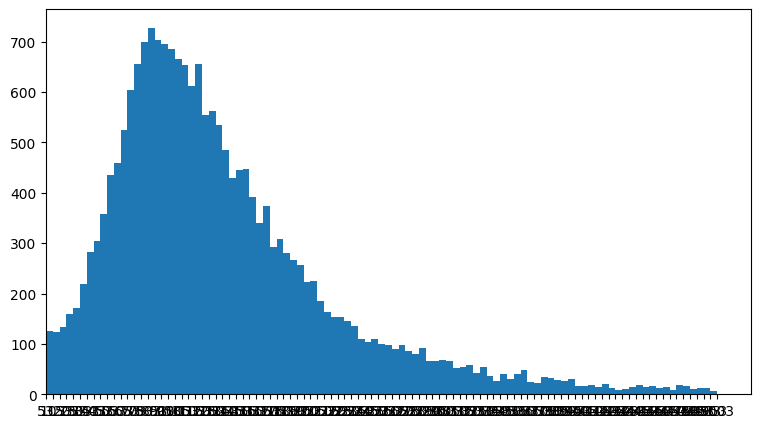

In [ ]:
plt.figure(figsize=[20,5])

plt.subplot(1, 2, 1)

bin_edges = np.arange(3+ 50, 5000 + 50 , 50)

plt.hist(data=data, x='population', bins = bin_edges);
plt.xlim(5000)
plt.xticks(np.arange(3.20+ 50,  5000 +50, 50));

##### Outliers

<Axes: xlabel='population'>

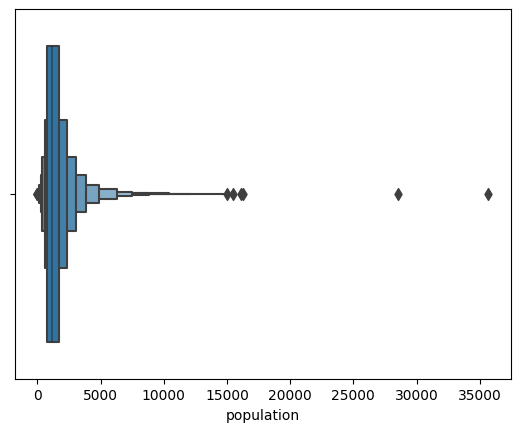

In [ ]:
sb.boxenplot(data= data, x= 'population')

#### households

In [ ]:
data.households.describe()

count    20640.000000
mean       499.539680
std        382.329753
min          1.000000
25%        280.000000
50%        409.000000
75%        605.000000
max       6082.000000
Name: households, dtype: float64

<Axes: xlabel='households'>

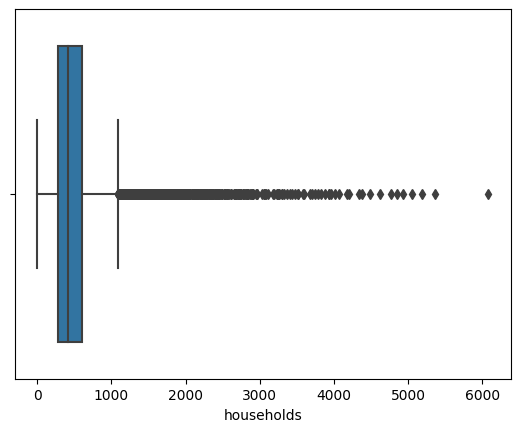

In [ ]:
sb.boxplot(data =data , x='households')

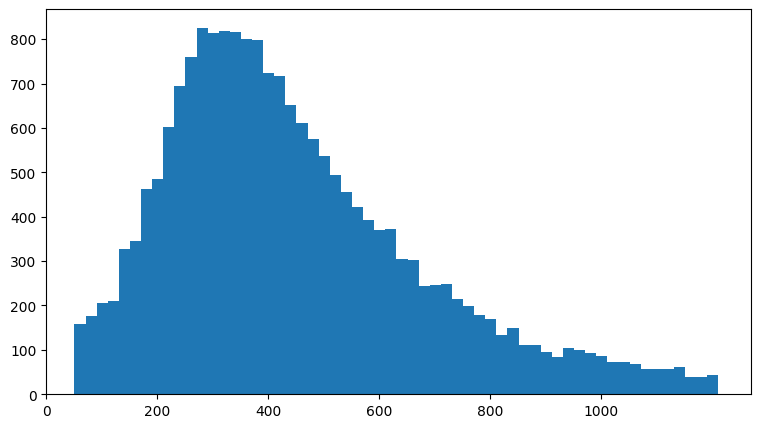

In [ ]:
plt.figure(figsize=[20,5])
plt.subplot(1, 2, 1)

bin_edges = np.arange(1 +50, 1200 +20 , 20)

plt.hist(data=data, x='households', bins = bin_edges);
plt.xlim(1200)

plt.xticks(np.arange(0,  900+ 200, 200));

#### median_income

In [ ]:
data.median_income.describe()

count    20640.000000
mean         3.870671
std          1.899822
min          0.499900
25%          2.563400
50%          3.534800
75%          4.743250
max         15.000100
Name: median_income, dtype: float64

<Axes: xlabel='median_income'>

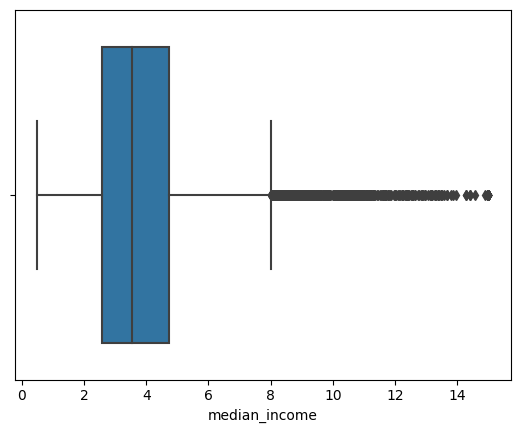

In [ ]:
sb.boxplot(data, x = 'median_income')


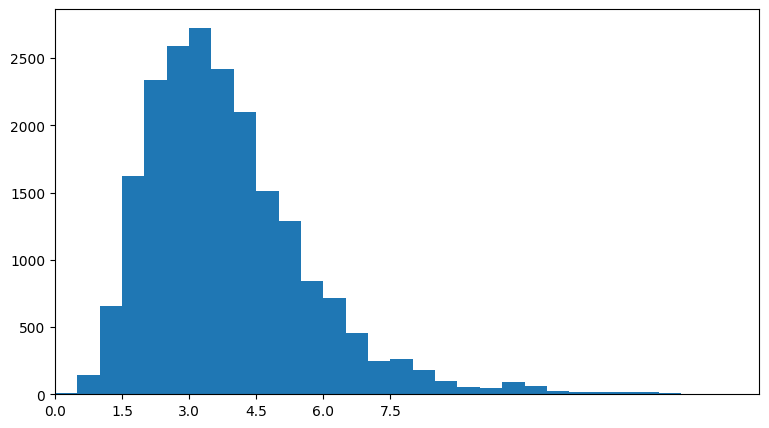

In [ ]:
plt.figure(figsize=[20,5])
plt.subplot(1, 2, 1)

bin_edges = np.arange(0 , 15  + 0.5 , 0.5)

plt.hist(data=data, x='median_income', bins = bin_edges);
plt.xlim(8)

plt.xticks(np.arange(0,  8 , 1.5));
# IQR

In [ ]:
num_values_gt_9 = data[data.median_income> 9].median_income.count()
num_values_gt_7 = data[data.median_income>7].median_income.count()
num_values_gt_5 = data[data.median_income>5].median_income.count()

print("num of values greater than 9 is {}".format(num_values_gt_9))
print("num of values greater than 7 is {}".format(num_values_gt_7))
print("num of values greater than 5 is {}".format(num_values_gt_5))

num of values greater than 9 is 407
num of values greater than 7 is 1199
num of values greater than 5 is 4489


#### ocean_proximity

In [ ]:
data.ocean_proximity.describe()

count         20640
unique            5
top       <1H OCEAN
freq           9136
Name: ocean_proximity, dtype: object

<Axes: xlabel='ocean_proximity', ylabel='count'>

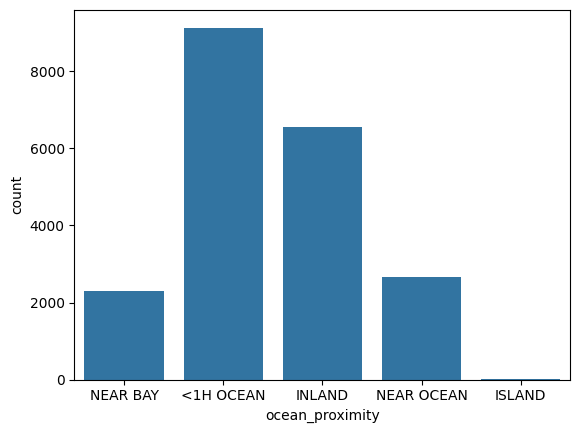

In [ ]:
base_color = sb.color_palette()[0]
sb.countplot(data = data , x = 'ocean_proximity', color = base_color)
# done

In [ ]:
num_of_island = data[data.ocean_proximity == 'ISLAND'].ocean_proximity.count()
print("number of ISLAND houses  {}".format(num_of_island))

number of ISLAND houses  5


#### longitude and latitude

<Axes: xlabel='longitude'>

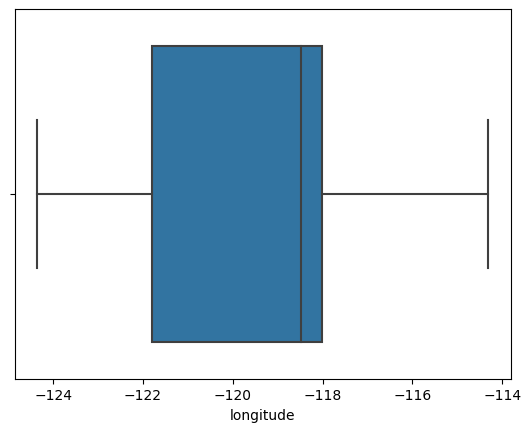

In [ ]:
sb.boxplot(data = data ,  x = 'longitude')

### Remove Outliers

In [ ]:
for c in data.columns:
  if data[c].dtype in ['int64', 'float64']:
    print_num_of_outlier(c, data)
    print("*******")


number of outliers in columns longitude is 0
percentage  of outliers in columns longitude is 0.0
*******
number of outliers in columns latitude is 0
percentage  of outliers in columns latitude is 0.0
*******
number of outliers in columns housing_median_age is 0
percentage  of outliers in columns housing_median_age is 0.0
*******
number of outliers in columns total_rooms is 1287
percentage  of outliers in columns total_rooms is 0.062354651162790695
*******
number of outliers in columns total_bedrooms is 1271
percentage  of outliers in columns total_bedrooms is 0.0622032985856213
*******
number of outliers in columns population is 1196
percentage  of outliers in columns population is 0.057945736434108525
*******
number of outliers in columns households is 1220
percentage  of outliers in columns households is 0.05910852713178295
*******
number of outliers in columns median_income is 681
percentage  of outliers in columns median_income is 0.03299418604651163
*******
number of outliers in c

In [ ]:
for c in data.columns:
  if data[c].dtype in ['int64', 'float64']:
    drop_outlier(c, data)

data.shape

(16902, 10)

### Bivariate analysis

In [ ]:
# 'longitude', 'latitude', 'housing_median_age', 'total_rooms',
#        'total_bedrooms', 'population', 'households', 'median_income',
#        'median_house_value', 'ocean_proximity'],


<Axes: xlabel='total_rooms', ylabel='median_house_value'>

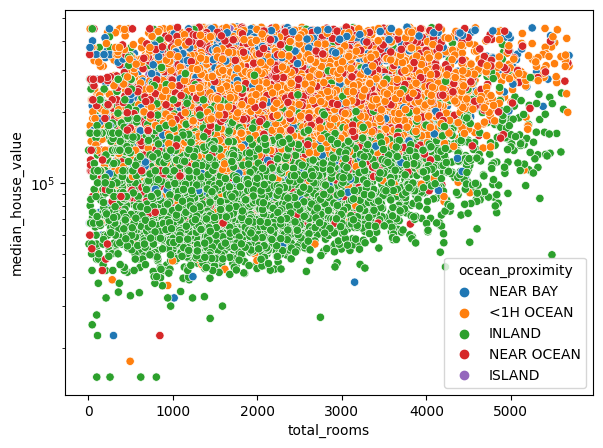

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.yscale("log")


sb.scatterplot(data, x ='total_rooms', y='median_house_value', hue='ocean_proximity')

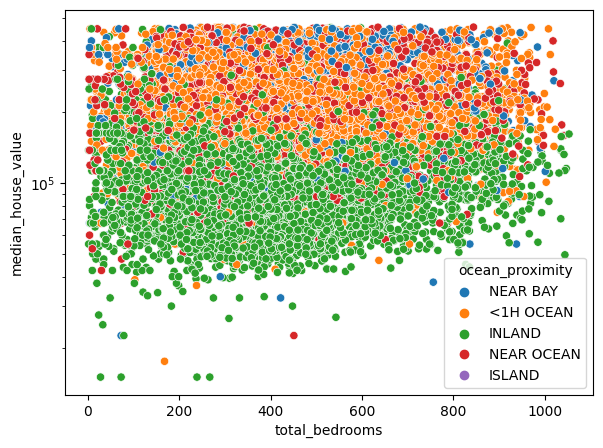

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sb.scatterplot(data, x ='total_bedrooms', y='median_house_value',  hue='ocean_proximity')
plt.yscale("log")

<Axes: xlabel='total_bedrooms', ylabel='total_rooms'>

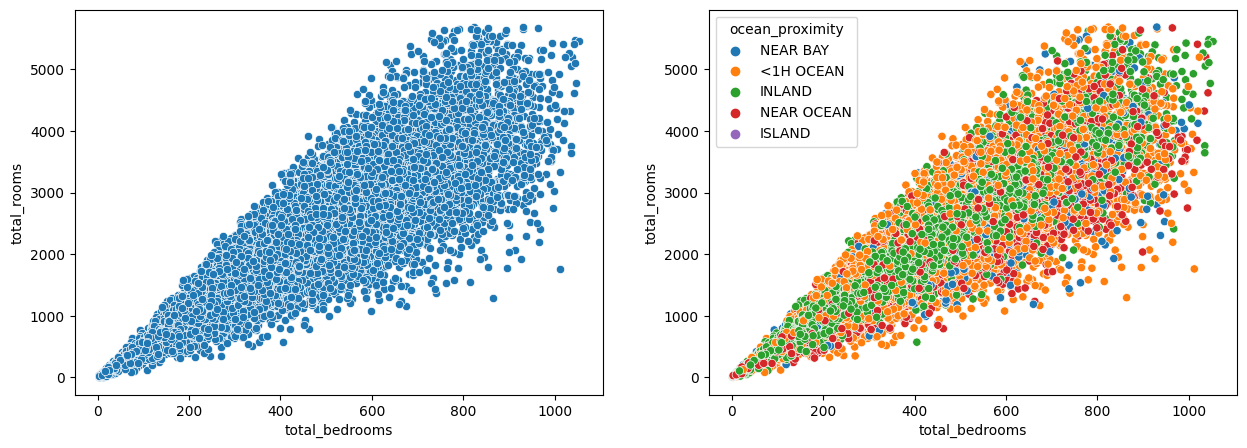

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sb.scatterplot(data, x ='total_bedrooms', y='total_rooms')
# plt.xscale("log")


plt.subplot(1,2,2)
sb.scatterplot(data, x ='total_bedrooms', y='total_rooms', hue='ocean_proximity')


<Axes: xlabel='population', ylabel='median_house_value'>

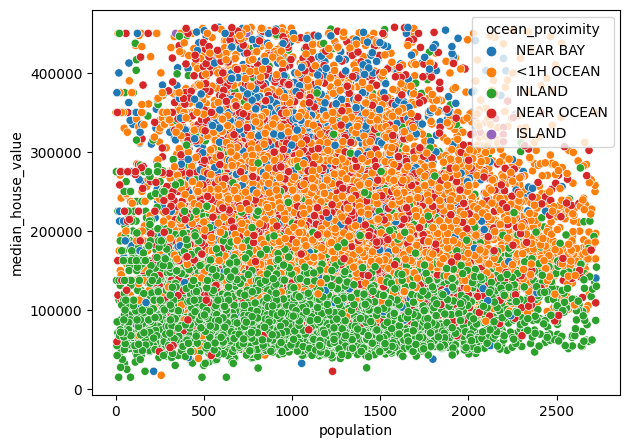

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sb.scatterplot(data, x ='population', y='median_house_value', hue="ocean_proximity")


<Axes: xlabel='population', ylabel='total_rooms'>

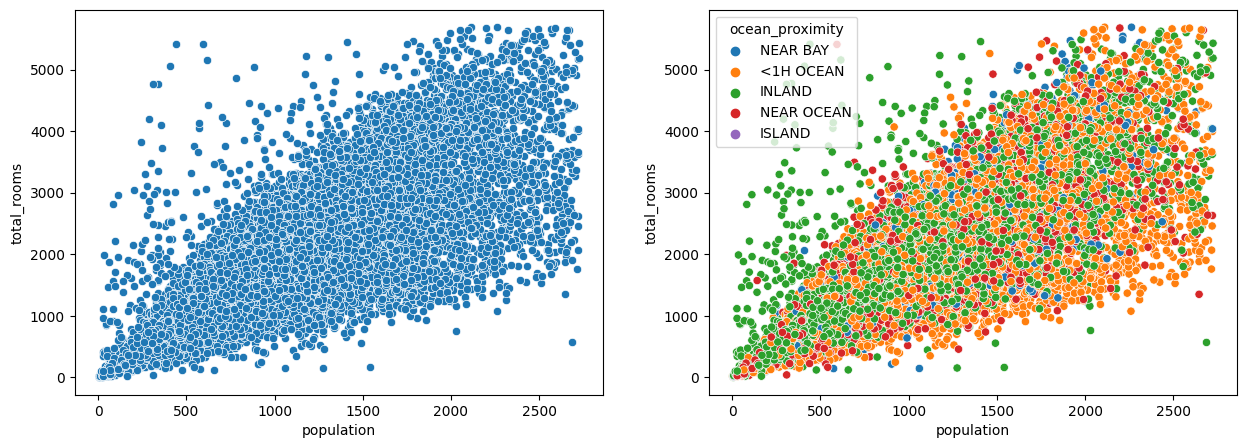

In [ ]:
## population
# households
# median_income
# median_house_value

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sb.scatterplot(data, x ='population', y='total_rooms')
# plt.xscale("log")


plt.subplot(1,2,2)
sb.scatterplot(data, x ='population', y='total_rooms', hue='ocean_proximity')



<Axes: xlabel='population', ylabel='households'>

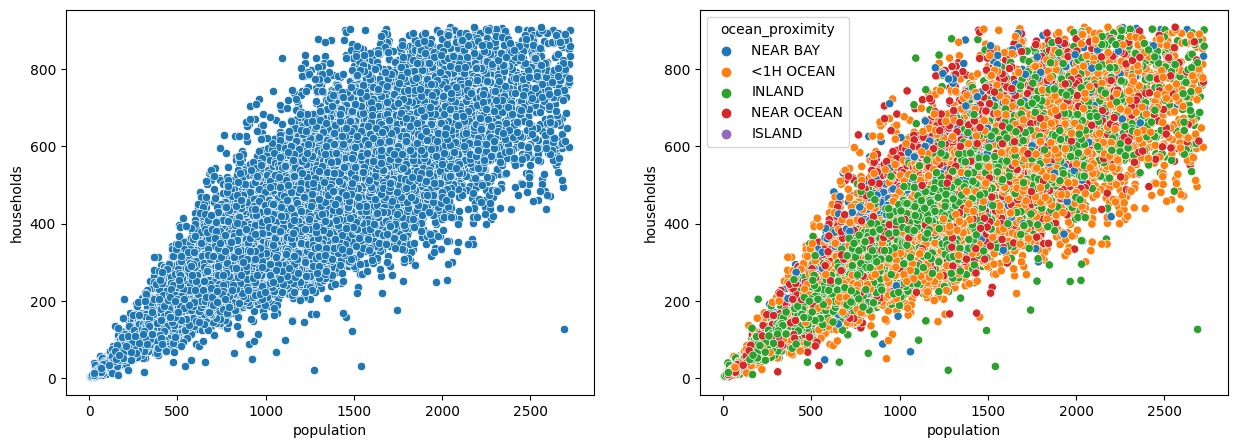

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sb.scatterplot(data, x ='population', y='households')
# plt.xscale("log")


plt.subplot(1,2,2)
sb.scatterplot(data, x ='population', y='households', hue='ocean_proximity')


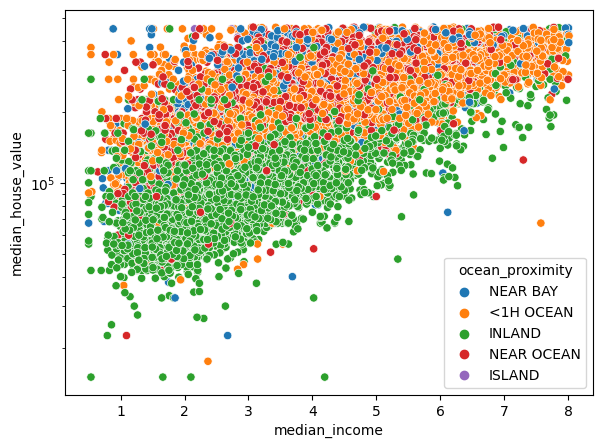

In [ ]:

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sb.scatterplot(data, x ='median_income', y='median_house_value', hue='ocean_proximity')
plt.yscale("log")


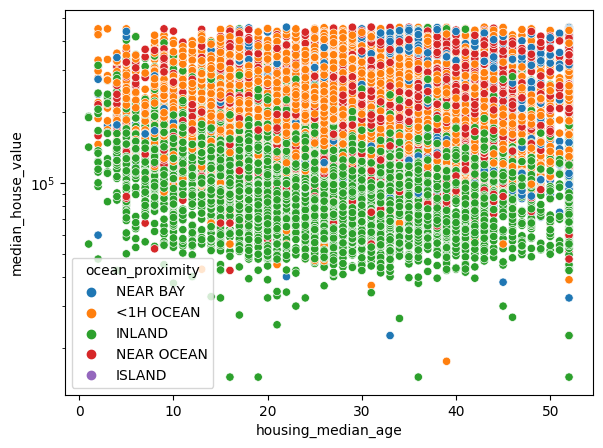

In [ ]:
# housing_median_age

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sb.scatterplot(data, x ='housing_median_age', y='median_house_value', hue='ocean_proximity')
plt.yscale("log")

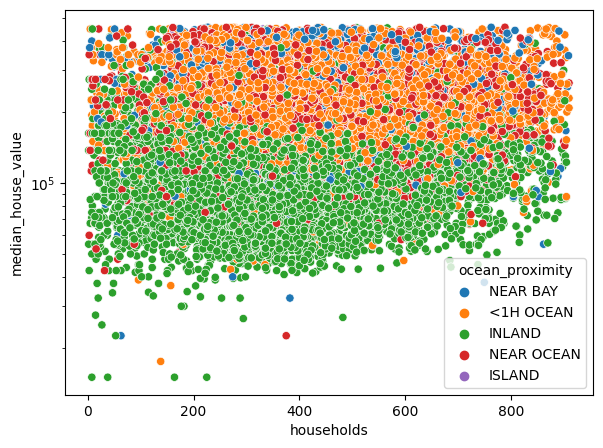

In [ ]:

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sb.scatterplot(data, x ='households', y='median_house_value', hue='ocean_proximity')
plt.yscale("log")

In [ ]:

#Define categorical and numerical features to prepare for data preprocessing
X_numerical = data.columns.drop(['median_house_value', 'ocean_proximity'])
X_categorical = ['ocean_proximity']


#Feature names : All column headers except house value
X = data.columns.drop(['median_house_value'])
#y Header
y = 'median_house_value'

print("X: ", X.values)
print("y: ", y)

X:  ['longitude' 'latitude' 'housing_median_age' 'total_rooms'
 'total_bedrooms' 'population' 'households' 'median_income'
 'ocean_proximity']
y:  median_house_value


### Outliers for categorical features (Anomalies)

We can think of outlier in categorical as values with low frequency - Or may be values which not correct, not applying to feature... A good way here is to Inspect looking at values and value counts

In [ ]:
for x in X_categorical:
    print(data[x].value_counts())
    print('----------------')

<1H OCEAN     7250
INLAND        5714
NEAR OCEAN    2121
NEAR BAY      1812
ISLAND           5
Name: ocean_proximity, dtype: int64
----------------


Noticed that we have an outlier for "ISLAND" value since it's count is too small in comparison with other values; Since this attribute (ocean_proximity is related to house location, we will check location median values for each region:



In [ ]:
print(data.groupby(x).median())

                 longitude  latitude  housing_median_age  total_rooms  \
ocean_proximity                                                         
<1H OCEAN          -118.26     34.02                32.0       1893.0   
INLAND             -120.15     37.30                25.0       1951.5   
ISLAND             -118.32     33.34                52.0       1675.0   
NEAR BAY           -122.25     37.78                40.0       1900.5   
NEAR OCEAN         -118.20     33.78                31.0       2036.0   

                 total_bedrooms  population  households  median_income  \
ocean_proximity                                                          
<1H OCEAN                 403.0      1161.0       387.0        3.74545   
INLAND                    391.0      1027.5       356.0        2.89255   
ISLAND                    512.0       733.0       288.0        2.73610   
NEAR BAY                  397.0       974.5       376.5        3.64430   
NEAR OCEAN                433.0      1078.0 

Looking at median values for longitude and latitude for each region, noticed that values are almost similar for "ISLAND" and "NEAR OCEAN", so, it's a good idea to replace ocean_proximity value of "ISLAND" with "NEAR OCEAN" to solve the problem of outlier

In [ ]:
data.loc[data["ocean_proximity"] == "ISLAND", "ocean_proximity"] = "NEAR OCEAN"

In [ ]:
print(data["ocean_proximity"].value_counts())
print('----------------')

<1H OCEAN     7250
INLAND        5714
NEAR OCEAN    2126
NEAR BAY      1812
Name: ocean_proximity, dtype: int64
----------------


### Search for Null values

In [ ]:
data.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        165
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [ ]:
# Replacing null values with median values, since data is skewed
data['total_bedrooms'] = data['total_bedrooms'].fillna(data['total_bedrooms'].median())
data.isnull().sum()


longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

### Apply one-hot-encoding for categorical feature

In [ ]:
new_val = pd.get_dummies(data.ocean_proximity)
new_val.head(10)

<1H OCEAN  INLAND  NEAR BAY  NEAR OCEAN
2           0       0         1           0
3           0       0         1           0
4           0       0         1           0
5           0       0         1           0
6           0       0         1           0
7           0       0         1           0
8           0       0         1           0
9           0       0         1           0
10          0       0         1           0
11          0       0         1           0

In [ ]:
# Adding new columns resulted from getdummies function
data[new_val.columns] = new_val
data = data[['longitude', 'latitude', 'housing_median_age', 'total_rooms',
        'total_bedrooms', 'population', 'households', 'median_income'
       , '<1H OCEAN', 'INLAND',
         'NEAR BAY', 'NEAR OCEAN','median_house_value']]
data.head(10)

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
2     -122.24     37.85                52.0       1467.0           190.0   
3     -122.25     37.85                52.0       1274.0           235.0   
4     -122.25     37.85                52.0       1627.0           280.0   
5     -122.25     37.85                52.0        919.0           213.0   
6     -122.25     37.84                52.0       2535.0           489.0   
7     -122.25     37.84                52.0       3104.0           687.0   
8     -122.26     37.84                42.0       2555.0           665.0   
9     -122.25     37.84                52.0       3549.0           707.0   
10    -122.26     37.85                52.0       2202.0           434.0   
11    -122.26     37.85                52.0       3503.0           752.0   

    population  households  median_income  <1H OCEAN  INLAND  NEAR BAY  \
2        496.0       177.0         7.2574          0       0         1   
3        558.0       219.0         5.6431          0       0         1   
4        565.0       259.0         3.8462          0       0         1   
5        413.0       193.0         4.0368          0       0         1   
6       1094.0       514.0         3.6591          0       0         1   
7       1157.0       647.0         3.1200          0       0         1   
8       1206.0       595.0         2.0804          0       0         1   
9       1551.0       714.0         3.6912          0       0         1   
10       910.0       402.0         3.2031          0       0         1   
11      1504.0       734.0         3.2705          0       0         1   

    NEAR OCEAN  median_house_value  
2            0            352100.0  
3            0            341300.0  
4            0            342200.0  
5            0            269700.0  
6            0            299200.0  
7            0            241400.0  
8            0            226700.0  
9            0            261100.0  
10           0            281500.0  
11           0            241800.0

Now, data in these columns make more since than just random big numbers, but their efficiency will be tested next in the Correlation Analysis.

### Adding New Features

In [ ]:
#Some Features like Numbers of rooms and bedrooms in a district might not be relevant. Hence, new dependent features are made out of aggregation.

data['rooms_per_household'] = data['total_rooms'] / data['households']
data['bedrooms_per_household'] = data['total_bedrooms'] / data['households']
data['bedrooms_per_rooms'] = data['total_bedrooms'] / data['total_rooms']
data.iloc[:,-3:]
X = data.columns.drop(['median_house_value'])


### Plot some correlations

Creating a Correlation Table First will help us to examine relations between different columns.



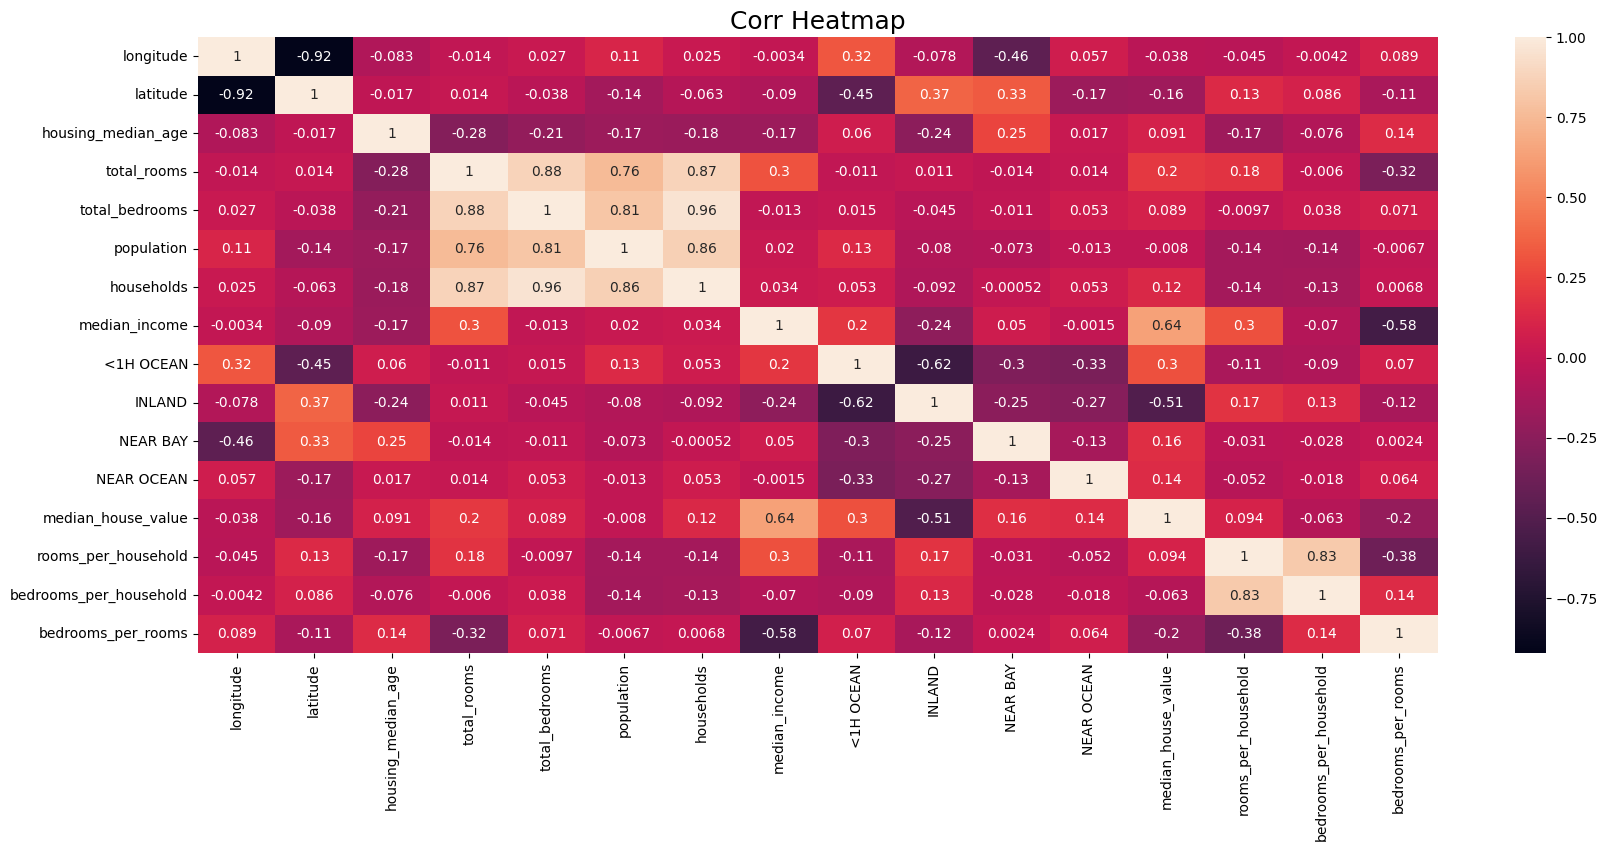

In [ ]:
plt.figure(figsize=(20, 8))
ax = sb.heatmap(data.corr(), annot=True)
ax.set_title('Corr Heatmap', fontdict={'fontsize': 18})
plt.show()

### Data Normalization


In [ ]:
from sklearn import preprocessing
#d = preprocessing.normalize(data, axis =0)
#data = pd.DataFrame(d, columns=data.columns)
#data.head(10)


### Splitting Data to train 80% and test 20%

In [ ]:
data_train, data_test = train_test_split(data, test_size = 0.2)


# AI Modeling

Apply advanced regression models, ensuring high predictive accuracy to predict housing prices given certain features.

## Multiple Linear Regression Model

In [ ]:
#we need to make sure to add a column for our intercept.
#Adding intercept column, constant = 1
data_train['intercept'] = 1
data_test['intercept'] = 1
X_with_intercept = data_train.columns
#OLS stands for ordinary least squares, as this is the method we want to use.
lm = sm.OLS(data_train[y], data_train[X_with_intercept])
results = lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     median_house_value   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 7.981e+31
Date:                Thu, 31 Aug 2023   Prob (F-statistic):               0.00
Time:                        17:10:34   Log-Likelihood:             2.7684e+05
No. Observations:               13521   AIC:                        -5.536e+05
Df Residuals:                   13505   BIC:                        -5.535e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
longitude               2.884e-12   5.65e-12      0.511      0.609   -8.18e-12     1.4e-11
latitude                 -8.9e-12   5.56e-12     -1.600      0.110   -1.98e-11       2e-12
housing_median_age     -1.538e-13   2.51e-13     -0.612      0.540   -6.46e-13    3.39e-13
total_rooms             2.212e-14   1.09e-14      2.032      0.042    7.81e-16    4.35e-14
total_bedrooms         -8.375e-14   7.02e-14     -1.194      0.233   -2.21e-13    5.38e-14
population             -2.062e-15   1.05e-14     -0.196      0.845   -2.27e-14    1.86e-14
households              2.398e-14   7.32e-14      0.328      0.743   -1.19e-13    1.67e-13
median_income          -1.661e-11   3.42e-12     -4.862      0.000   -2.33e-11   -9.91e-12
<1H OCEAN               2.632e-10    9.8e-11      2.685      0.007     7.1e-11    4.55e-10
INLAND                  2.747e-10   9.33e-11      2.945      0.003    9.18e-11    4.58e-10
NEAR BAY                1.235e-10   1.01e-10      1.228      0.220   -7.37e-11    3.21e-10
NEAR OCEAN              2.552e-10      1e-10      2.552      0.011    5.92e-11    4.51e-10
median_house_value         1.0000   4.73e-17   2.11e+16      0.000       1.000       1.000
rooms_per_household     1.991e-13    5.7e-12      0.035      0.972    -1.1e-11    1.14e-11
bedrooms_per_household  1.538e-11   2.42e-11      0.636      0.525    -3.2e-11    6.28e-11
bedrooms_per_rooms     -6.137e-11   1.06e-10     -0.579      0.563   -2.69e-10    1.46e-10
intercept               7.452e-10   3.91e-10      1.905      0.057   -2.15e-11    1.51e-09
==============================================================================
Omnibus:                     3571.610   Durbin-Watson:                   0.086
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8083.883
Skew:                           1.512   Prob(JB):                         0.00
Kurtosis:                       5.281   Cond. No.                     1.63e+21
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.2e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [ ]:
results._results.params

array([ 2.88419381e-12, -8.90005516e-12, -1.53754125e-13,  2.21157539e-14,
       -8.37486522e-14, -2.06224952e-15,  2.39841489e-14, -1.66062618e-11,
        2.63206250e-10,  2.74682283e-10,  1.23497018e-10,  2.55249463e-10,
        1.00000000e+00,  1.99059627e-13,  1.53780847e-11, -6.13741037e-11,
        7.45194659e-10])

#### Use the fitted parameters to predict the price of houses in the testing data

In [ ]:
predictions = results.predict(data_test[X_with_intercept])
predictions.name = 'predictedPrice'
predictions

703      241900.0
12749    166100.0
13198    114400.0
7676     170800.0
6611     376000.0
           ...   
13070    112500.0
3816     202000.0
19907     72200.0
8777     254700.0
4091     355900.0
Name: predictedPrice, Length: 3381, dtype: float64

#### Compute the RSS for the testing data

In [ ]:
#Creating new data frame from test data for y values and predicted y values
predictedDf = pd.DataFrame({'y':data_test[y], 'predictedY':predictions})
predictedDf.head()

y  predictedY
703    241900.0    241900.0
12749  166100.0    166100.0
13198  114400.0    114400.0
7676   170800.0    170800.0
6611   376000.0    376000.0

In [ ]:
predictedDf['r'] = (predictedDf.predictedY - predictedDf.y)
predictedDf['rs'] = predictedDf.r ** 2
predictedDf.head()

RSS = predictedDf['rs'].sum()
RSS

3.2789797154498885e-16

### Multiple Linear Regression Summary

RSS value is too small, value near to Zero which means that our model perfectly fits

So that we will rely on this model regression to predict house prices

## Random Forest Model

In [ ]:
def applyRandomForest(df_train, df_test, X, y):
    # Splitting train dataframe to train and test data as 80/20:
    # test_size: 0.2

    train_split, test_split = train_test_split(df_train, test_size = 0.2)

    #We will use splitted data train and test for this part also
    rf_clf = RandomForestRegressor(max_depth=5, random_state=0)
    rf_clf.fit(train_split[X], train_split[y])

    #Predict the response for our test data
    df_test['predicted'] = rf_clf.predict(df_test[X])

    #To compare the accuracy,,
    # Evaluate scores for training and testing(splitted from train data)
    # Function score(X, y[, sample_weight])	Returns the mean accuracy on the given test data and labels.
    print('Training accuracy score: ', rf_clf.score(train_split[X], train_split[y]))
    print('Test accuracy score: ', rf_clf.score(test_split[X], test_split[y]))


In [ ]:
applyRandomForest(data_train, data_test, X, y)

Training accuracy score:  0.6262704303891625
Test accuracy score:  0.6345477522008665


## Decision Trees

In [ ]:
def applyDecisionTrees(df_train, df_test, X, y):
    # Create Decision Tree classifer object
    dtree_clf = DecisionTreeRegressor()

    # Train Decision Tree Classifer
    dtree_clf.fit(df_train[X],df_train[y])

    #Predict the response for test data
    df_test['predicted'] = dtree_clf.predict(df_test[X])

    # Finding training and testing accuracy(splitting our train data) using k-fold cross validation
    dtree_cv_results = cross_validate(dtree_clf, df_train[X], df_train[y], cv=5, return_train_score = True)

    print('Training accuracy:')
    #train_score: The score array for train scores on each cv split.
    print('Scores: ', dtree_cv_results['train_score'])
    print('Average: ', dtree_cv_results['train_score'].mean())

    print('\nTesting accuracy:')
    #test_score: The score array for test scores on each cv split.
    print('Scores: ', dtree_cv_results['test_score'])
    print('Average: ', dtree_cv_results['test_score'].mean())

## GradiantBoosting Optimization

In [ ]:
from sklearn.metrics import mean_absolute_error, f1_score, mean_squared_error, accuracy_score

def applyDecisonTreeRrgressoor(df_train, df_test,X, y):

    train_split, test_split = train_test_split(df_train, test_size = 0.2)

    model = DTR(max_depth=5)
    model.fit(train_split[X], train_split[y])

    predictinos = model.predict(test_split[X])

    print("mean absolute error ", mean_absolute_error(predictinos, test_split[y]))

    print("mse is ", mean_squared_error(predictinos,  test_split[y] ))



In [ ]:
applyDecisonTreeRrgressoor(data_train, data_test, X, y)


mean absolute error  43551.917870406025
mse is  3449786877.905301


In [ ]:
# Sample object
house = {}
house['longitude']=-118.42
house['latitude']= 34.15
house['housing_median_age']= 31.0
house['total_rooms']= 1861.0
house['total_bedrooms']= 430.0
house['population']= 736.0
house['households']= 360.0
house['median_income']= 5.2853
house['<1H OCEAN']= 1
house['INLAND']= 0
house['NEAR BAY']= 0
house['NEAR OCEAN']= 0
house['rooms_per_household']=5.169444
house['bedrooms_per_household']=1.19444
house['bedrooms_per_rooms']=0.231059




In [ ]:
def predictPrice(house_data):
  new_df = pd.DataFrame()
  new_df = new_df.append(house_data , ignore_index=True)

  print("______", new_df)

  predictions = results.predict(new_df[X])
  predictions.name = 'predictedPrice'
  return predictions


print(predictPrice(house))


______    longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -118.42     34.15                31.0       1861.0           430.0   

   population  households  median_income  <1H OCEAN  INLAND  NEAR BAY  \
0       736.0       360.0         5.2853        1.0     0.0       0.0   

   NEAR OCEAN  rooms_per_household  bedrooms_per_household  \
0         0.0             5.169444                 1.19444   

   bedrooms_per_rooms  intercept  
0            0.231059        1.0  


<ipython-input-385-de0e9b43972a>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(house_data , ignore_index=True)


ValueError: ignored